# Ethereum Fraud Detection

## Install Packages

In [100]:
%pip install pandas numpy scikit-learn matplotlib seaborn category_encoders

Note: you may need to restart the kernel to use updated packages.


## Import Packages

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders import TargetEncoder

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

## Load Data

In [102]:
df = pd.read_csv('dataset.csv')

## Data Exploration and Preprocessing

In [103]:
df.shape

(9841, 51)

In [104]:
df.head()

,Unnamed: 0,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9841 entries, 0 to 9840
Data columns (total 51 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Unnamed: 0                                            9841 non-null   int64  
 1   Index                                                 9841 non-null   int64  
 2   Address                                               9841 non-null   object 
 3   FLAG                                                  9841 non-null   int64  
 4   Avg min between sent tnx                              9841 non-null   float64
 5   Avg min between received tnx                          9841 non-null   float64
 6   Time Diff between first and last (Mins)               9841 non-null   float64
 7   Sent tnx                                              9841 non-null   int64  
 8   Received Tnx                                          9841

In [106]:
df.columns = df.columns.str.strip().str.replace(r'\b\s+\b', '_', regex=True)
df.columns

Index(['Unnamed: 0', 'Index', 'Address', 'FLAG', 'Avg_min_between_sent_tnx',
       'Avg_min_between_received_tnx',
       'Time_Diff_between_first_and_last (Mins)', 'Sent_tnx', 'Received_Tnx',
       'Number_of_Created_Contracts', 'Unique_Received_From_Addresses',
       'Unique_Sent_To_Addresses', 'min_value_received', 'max_value_received',
       'avg_val_received', 'min_val_sent', 'max_val_sent', 'avg_val_sent',
       'min_value_sent_to_contract', 'max_val_sent_to_contract',
       'avg_value_sent_to_contract',
       'total_transactions (including_tnx_to_create_contract',
       'total_Ether_sent', 'total_ether_received',
       'total_ether_sent_contracts', 'total_ether_balance', 'Total_ERC20_tnxs',
       'ERC20_total_Ether_received', 'ERC20_total_ether_sent',
       'ERC20_total_Ether_sent_contract', 'ERC20_uniq_sent_addr',
       'ERC20_uniq_rec_addr', 'ERC20_uniq_sent_addr.1',
       'ERC20_uniq_rec_contract_addr', 'ERC20_avg_time_between_sent_tnx',
       'ERC20_avg_time_be

In [107]:
df.duplicated(subset='Index').sum()

5112

In [108]:
# Proportion of FLAG in overall data
df['FLAG'].value_counts(normalize=True)

FLAG
0    0.778579
1    0.221421
Name: proportion, dtype: float64

In [109]:
# Proportion of FLAG in duplicated rows
df[df.duplicated(subset='Index')]['FLAG'].value_counts(normalize=True)

FLAG
0    0.573748
1    0.426252
Name: proportion, dtype: float64

In [110]:
df.duplicated().sum()

0

In [111]:
df = df.drop(columns= ['Unnamed: 0', 'Index', 'Address'])

### Identify different column types

In [112]:
categories = df.select_dtypes(include='object').columns

In [113]:
for i in df[categories].columns:
    print(f'The categorical column {i} has {df[i].nunique()} unique values and {df[i].isnull().sum()} missing values')

The categorical column ERC20_most_sent_token_type has 304 unique values and 2697 missing values
The categorical column ERC20_most_rec_token_type has 466 unique values and 871 missing values


In [114]:
numerics = df.select_dtypes(include='number').columns

### Identify zero variance columns

In [115]:
df[numerics].var()[df[numerics].var() == 0].index
constant_cols = df[numerics].var()[df[numerics].var() == 0].index

In [116]:
# Drop constant columns
df.drop(constant_cols, axis=1, inplace=True)

### Correlation Matrix

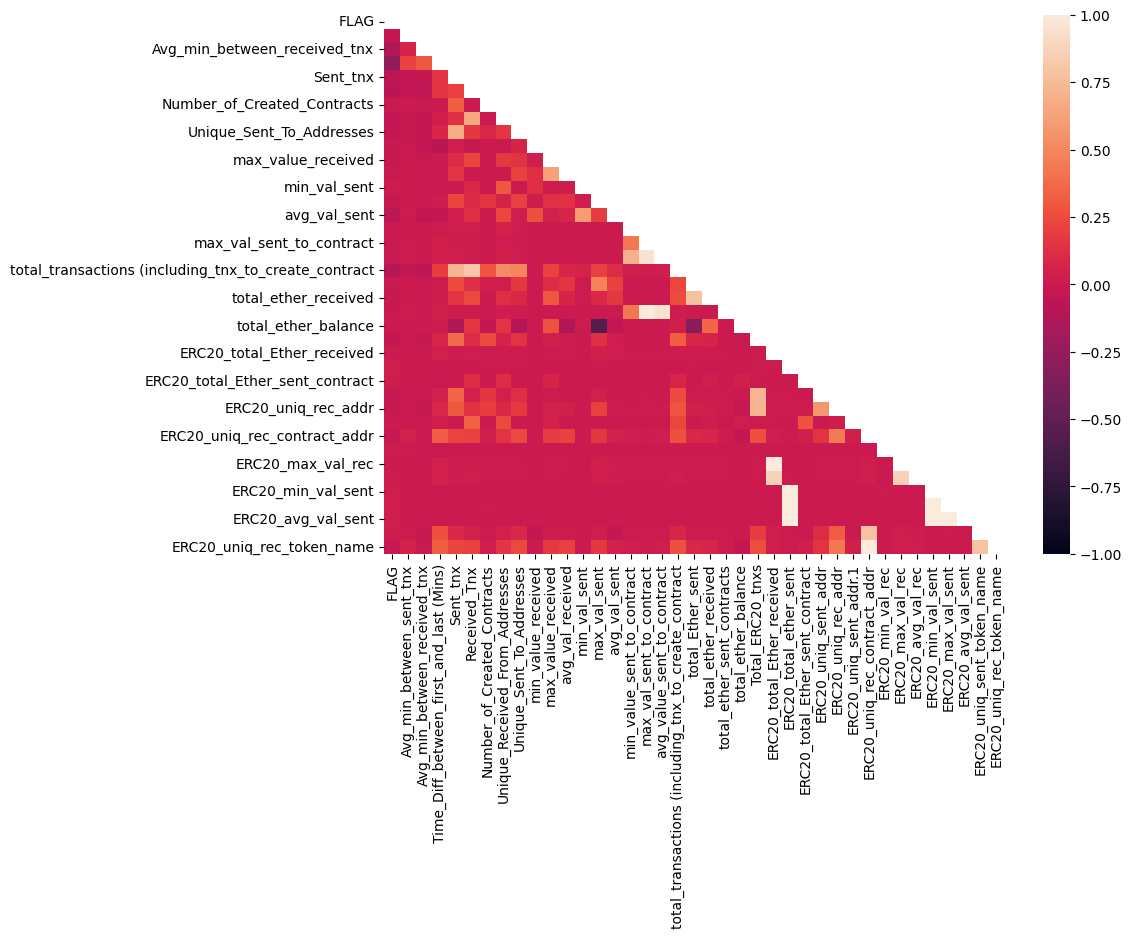

In [117]:
plt.figure(figsize=(10,7))
numerics = df.select_dtypes(include='number').columns
corr = df[numerics].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
sns.heatmap(corr, mask=mask, annot=False, vmin=-1, vmax=1)
plt.show()

### Visualize Missing Patterns

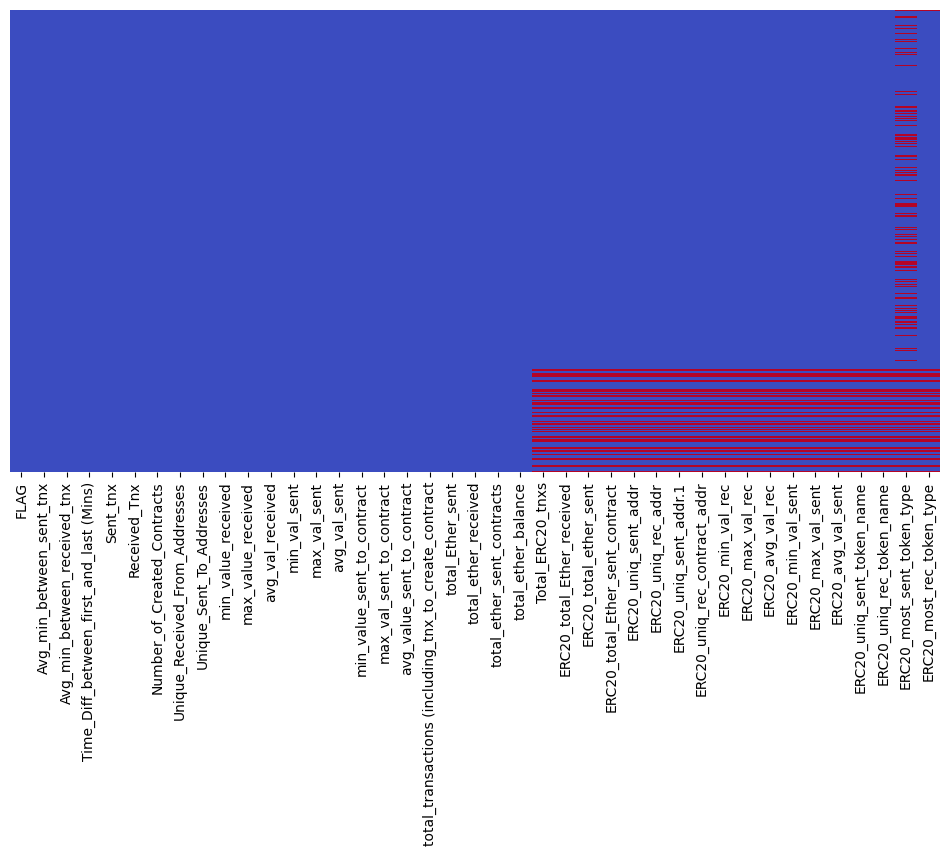

In [118]:
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cmap='coolwarm', cbar=False)
plt.yticks([])
plt.show()

In [119]:
missing_rows_count = df.isnull().any(axis=1).sum()
print(f"The number of rows with missing data is: {missing_rows_count}" )

The number of rows with missing data is: 2720


In [120]:
missing_mask = df.isnull().any(axis=1)
print(df.loc[missing_mask, 'FLAG'].value_counts())
print("\n")
print(round(df.loc[missing_mask, 'FLAG'].value_counts(normalize=True), 2))

FLAG
0    1891
1     829
Name: count, dtype: int64


FLAG
0    0.7
1    0.3
Name: proportion, dtype: float64


In [121]:
print(df['FLAG'].value_counts())
print('\n')
print(round(df['FLAG'].value_counts(normalize=True), 2))

FLAG
0    7662
1    2179
Name: count, dtype: int64


FLAG
0    0.78
1    0.22
Name: proportion, dtype: float64


In [122]:
print(df[~missing_mask].shape)
df_sub = df[~missing_mask]

(7121, 41)


In [123]:
X = df_sub.drop('FLAG', axis=1)
y = df_sub['FLAG']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

### Encoding Object Values

In [124]:
encoder = TargetEncoder(cols=categories)

X_train_encoded = encoder.fit_transform(X_train, y_train)

X_test_encoded = encoder.transform(X_test)

In [125]:
train = pd.concat([X_train_encoded, y_train], axis=1)
test = pd.concat([X_test_encoded, y_test], axis=1)

## Building and Training Model

In [126]:
isolation_forest = IsolationForest(contamination='auto', random_state=123)

isolation_forest.fit(train)

anomaly_train_pred = isolation_forest.predict(train)
anomaly_test_pred = isolation_forest.predict(test)

is_train = np.sum(anomaly_train_pred == -1)
is_test = np.sum(anomaly_test_pred == -1)

print("Number of outliers in the training set: ", is_train)
print("Number of outliers in the test set: ", is_test)

Number of outliers in the training set:  196
Number of outliers in the test set:  55


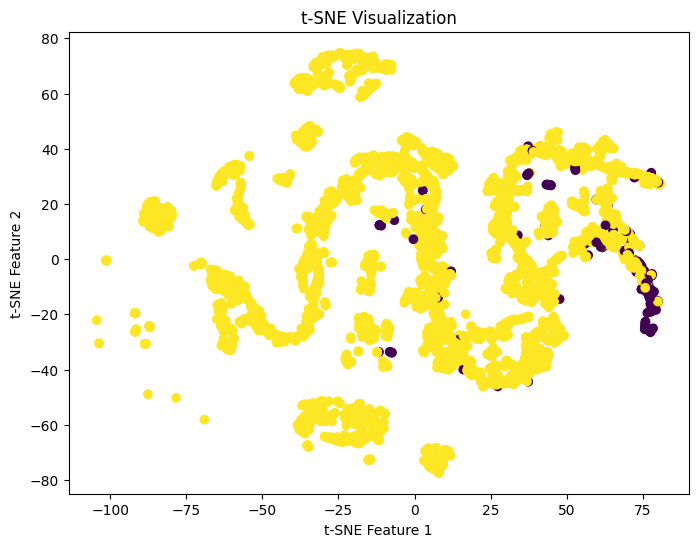

In [130]:
tsne = TSNE(n_components=2, random_state=123)
X_train_tsne = tsne.fit_transform(X_train_encoded)

plt.figure(figsize=(8,6))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=anomaly_train_pred)


In [131]:
X_test_tsne = tsne.fit_transform(X_test_encoded)

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=anomaly_test_pred)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()